In [1]:
from dataloader import load_balanced_dataset
import backend.src.utils.utils as utils

In [2]:
data = load_balanced_dataset()
data = utils.clean_text(data, "text")

In [3]:
data

,sent_id,text,label
5789,704907-11-02,taylor trengte to plukk gitaren salen brøt var...,2
1147,201734-24-02,ytelsen nok individuelt klarer jo alt bortsett...,2
6994,704974-03-02,kombinerer gamle sirkustricks nøye innstuderte...,2
7665,001521-07-03,låter heroes axe to fall viser converge voksne...,2
4833,202276-21-05,tåkelys foran bak •,2
...,...,...,...
4263,108264-06-04,nok fylle hel bok einstein norge,0
10001,105373-13-01,konserten øya likevel skjemmet lysdesigner eks...,0
2484,107878-07-01,største problemet football manager tør stole f...,0
5252,110737-08-02,filmens svakhet,0


<AxesSubplot:>

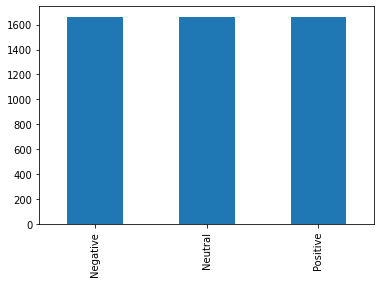

In [4]:
data["label"].replace({0: "Negative", 1: "Neutral", 2: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

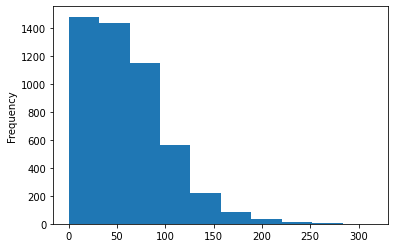

In [5]:
data["text"].str.len().plot.hist()

In [6]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"], test_size=0.1, random_state=42,
                                                    shuffle=True)

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [7]:
from random import randint

random_idx = randint(0, len(X_train))
review_label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
review_label = review_label_mapping[int(y_train.iloc[random_idx])]

print(f"Review {random_idx} contains {len(X_train[random_idx])} words and is {review_label}")
print("Review content:", end="\n\n")
print(" ".join(tokenizer.index_word[idx] for idx in X_train[random_idx]))

Review 918 contains 6 words and is Positive
Review content:

se dyrt smykke butikk billige suvenirer


In [8]:
from collections import Counter

word_counter = Counter()
for review in X_train:
    for word in review:
        word_counter[tokenizer.index_word[word]] += 1

In [9]:
word_counter.most_common(10)

[('litt', 166),
 ('får', 135),
 ('the', 132),
 ('filmen', 119),
 ('to', 116),
 ('gjør', 113),
 ('helt', 110),
 ('godt', 105),
 ('første', 92),
 ('nok', 90)]

In [10]:
maxlen = 100

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [11]:
from keras.utils.np_utils import to_categorical
import numpy as np

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [12]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (4490, 100)
X_test shape: (499, 100)


In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, trainable=True))
model.add(LSTM(units=128, dropout=0.5, return_sequences=True))
model.add(LSTM(units=128, dropout=0.5))
model.add(Dense(3, activation='softmax'))

In [14]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 2,823,555
Trainable params: 2,823,555
Non-trainable params: 0
_________________________________________________________________


In [15]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 20
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

Epoch 1/20
225/225 [==============================] - 53s 220ms/step - loss: 1.0790 - accuracy: 0.3937 - val_loss: 1.0548 - val_accuracy: 0.4254
Epoch 2/20
225/225 [==============================] - 45s 202ms/step - loss: 0.7999 - accuracy: 0.6384 - val_loss: 1.0116 - val_accuracy: 0.5479
Epoch 3/20
225/225 [==============================] - 46s 204ms/step - loss: 0.3404 - accuracy: 0.8658 - val_loss: 1.1956 - val_accuracy: 0.5278
Epoch 4/20
225/225 [==============================] - 60s 269ms/step - loss: 0.1305 - accuracy: 0.9585 - val_loss: 1.4797 - val_accuracy: 0.5200
Epoch 5/20
225/225 [==============================] - 56s 249ms/step - loss: 0.0613 - accuracy: 0.9822 - val_loss: 2.0296 - val_accuracy: 0.5267


In [16]:
from datetime import datetime

model.save(f"models/SA-LSTM-MULTICLASS-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

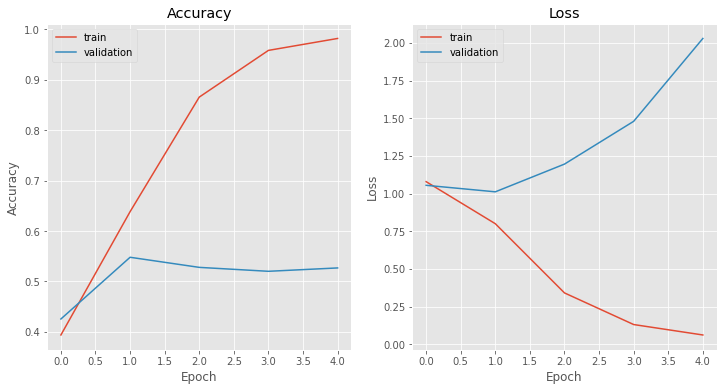

In [17]:
from backend.src.utils.utils import plot_history

plot_history(history)

In [18]:
# Evaluation
val_loss, val_acc = model.evaluate(X_test, y_test)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

16/16 [==============================] - 1s 87ms/step - loss: 2.2017 - accuracy: 0.5351
Validation loss: 2.201673746109009
Validation accuracy: 0.5350701212882996
